## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [2]:
# pandas and numpy
import pandas as pd
import numpy as numpy

import spacy
import scattertext as st

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets = congress_tweets.sample(frac=0.05, random_state=123)
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
739141,1.091840e+18,RepCohen,2019-02-02T18:30:00-05:00,#Trump says he won’t read the border security ...,Steve Cohen,Rep,3-Jan-07,5/24/1949,M,TN,9,Democrat,"1,522,925","870,695","960,709","1,462,330"
800943,1.228690e+18,JohnCornyn,2020-02-15T09:21:21-05:00,How China’s Quest for Dominance Is an All-Enco...,John Cornyn,Sen,2-Dec-02,2/2/1952,M,TX,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
692886,1.224900e+18,RepDwightEvans,2020-02-04T22:44:23-05:00,RT @SpeakerPelosi .@GovWhitmer delivers the De...,Dwight Evans,Rep,14-Nov-16,5/16/1954,M,PA,3,Democrat,"2,970,733","2,926,441","2,990,274","2,680,434"
769234,1.118650e+18,RepDanCrenshaw,2019-04-17T19:05:45-04:00,Very cool visit to our local Coast Guard stati...,Dan Crenshaw,Rep,3-Jan-19,3/14/1984,M,TX,2,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
659002,1.249810e+18,SenatorLankford,2020-04-13T17:24:41-04:00,RT @USTreasury Over 80 million Americans will ...,James Lankford,Sen,3-Jan-15,3/4/1968,M,OK,Senate,Republican,"949,136","420,375","443,547","891,325"


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [4]:
# View sample of tweet texts 
congress_tweets["text"].head(-10)


739141    #Trump says he won’t read the border security ...
800943    How China’s Quest for Dominance Is an All-Enco...
692886    RT @SpeakerPelosi .@GovWhitmer delivers the De...
769234    Very cool visit to our local Coast Guard stati...
659002    RT @USTreasury Over 80 million Americans will ...
                                ...                        
513202    Over the weekend I visited the First Presbyter...
78749     If you or someone you know needs help, you can...
65339     "Let's quit focusing on areas where we have cl...
402219    RT @TravelGov Travel Advisory: Level 4 - The D...
196022    I introduced my annual resolution to designate...
Name: text, Length: 47330, dtype: object

In [5]:
sample_corpus = congress_tweets.sample(frac=0.075, random_state=123)

In [6]:

# Add some flags to stopwords 
nlp.Defaults.stop_words.add('RT')

import re

# function to remove URLs from tweets
def remove_urls(text):
    # Regex to match URLs starting with http or https
    url_pattern = r'https?://\S+|www\.\S+'
    # Replace URLs found in the text with an empty string
    no_urls = re.sub(url_pattern, '', text)
    return no_urls

In [7]:
def rem_punc_stop(text):
    # Remove return characters
    text_no_returns = text.replace('\n', ' ').replace('\r', ' ')
    
    # Set stop words
    stop_words = STOP_WORDS
    # Define punctuation
    punc = set(punctuation)
    
    # Remove punctuation
    punc_free_text = "".join(ch for ch in text_no_returns if ch not in punc)
    
    # Remove URLs
    url_free_text = remove_urls(punc_free_text)
    
    # Process the text with spaCy
    doc = nlp(url_free_text)
    
    # Filter out stop words and tokens that start with 'http'
    tokens = [token.text for token in doc if token.text not in stop_words and not token.text.startswith('http')]
    
    return tokens


In [8]:
# apply rem_punc_stop to tweet text
sample_corpus['Cleaned Tweets'] = sample_corpus['text'].apply(rem_punc_stop)

In [9]:
sample_corpus['Cleaned Tweets'].iloc[1]

['REMINDER',
 'Today',
 'day',
 'history',
 'vote',
 'early',
 'Polls',
 'open',
 '10',
 'PM',
 'tonight',
 'Bexar',
 'County',
 'Travis',
 'County',
 'sites',
 'open',
 '7',
 'PM',
 'megacenters',
 'open',
 '9',
 'PM',
 ' ',
 '⭐',
 'Find',
 'location',
 'vote',
 'near',
 'thread',
 'QT',
 'RepLloydDoggett',
 'TEXANS',
 'To',
 'vote',
 'counted',
 'vote',
 'early',
 'Early',
 'voting',
 'underway',
 'NOW',
 '—',
 'ends',
 'Friday',
 'Here',
 'cast',
 'ballot',
 'history',
 'today',
 'thread',
 ' ',
 'VoteEarly']

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1

### Firstly I'm curious to look at word frequency. In our polarized world, I hypothesize that some key words will spike for different parties 

In [10]:
sample_corpus.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,Cleaned Tweets
512422,1.167490e+18,RepJoshG,2019-08-30T13:24:21-04:00,"(2/2) ...new additions, including a space for ...",Josh Gottheimer,Rep,3-Jan-17,3/8/1975,M,NJ,5,Democrat,"1,601,933","2,148,278","2,125,101","1,477,568","[22, new, additions, including, space, senior,..."
836410,1.322260e+18,RepLloydDoggett,2020-10-30T15:51:54-04:00,REMINDER: Today is the last day to make histor...,Lloyd Doggett,Rep,3-Jan-95,10/6/1946,M,TX,35,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843","[REMINDER, Today, day, history, vote, early, P..."
780930,1.164660e+18,JohnCornyn,2019-08-22T18:06:54-04:00,RT @JeffBoydTX #tbt to both endorsements from ...,John Cornyn,Sen,2-Dec-02,2/2/1952,M,TX,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[JeffBoydTX, tbt, endorsements, TX, Senators, ..."
688254,1.187430e+18,SenBobCasey,2019-10-24T14:24:21-04:00,Deputy Assistant Secretary of Defense Laura Co...,Bob Casey Jr.,Sen,3-Jan-07,4/13/1960,M,PA,Senate,Democrat,"2,970,733","2,926,441","2,990,274","2,680,434","[Deputy, Assistant, Secretary, Defense, Laura,..."
107340,1.223390e+18,SenFeinstein,2020-01-31T18:41:10-05:00,Jurors in a trial should have access to all th...,Dianne Feinstein,Sen,4-Nov-92,6/22/1933,F,CA,Senate,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[Jurors, trial, access, relevant, information,..."


In [11]:
# Congress_tweets['Cleaned Tweets'] contains lists of words, we need a string for scatter text 
sample_corpus['C Tweets String'] = sample_corpus['Cleaned Tweets'].apply(lambda x: ' '.join(x))

In [12]:
corpus = st.CorpusFromPandas(sample_corpus[:5000], # data set
                             category_col='party', # select the explanatory variable
                             text_col='C Tweets String', # select text column
                             nlp=nlp).build() # apply nlp algo 

In [13]:
# create html document
html = st.produce_scattertext_explorer(corpus,
                                       category='Democrat',
                                       category_name='Democrat',
                                       not_category_name='Republican',
                                       width_in_pixels=1000,
                                       minimum_term_frequency=5)

open('./simple.html', 'wb').write(html.encode('utf-8'))
print('Open ./simple.html in Chrome or Firefox.')

Open ./simple.html in Chrome or Firefox.


In [14]:
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
739141,1.091840e+18,RepCohen,2019-02-02T18:30:00-05:00,#Trump says he won’t read the border security ...,Steve Cohen,Rep,3-Jan-07,5/24/1949,M,TN,9,Democrat,"1,522,925","870,695","960,709","1,462,330"
800943,1.228690e+18,JohnCornyn,2020-02-15T09:21:21-05:00,How China’s Quest for Dominance Is an All-Enco...,John Cornyn,Sen,2-Dec-02,2/2/1952,M,TX,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
692886,1.224900e+18,RepDwightEvans,2020-02-04T22:44:23-05:00,RT @SpeakerPelosi .@GovWhitmer delivers the De...,Dwight Evans,Rep,14-Nov-16,5/16/1954,M,PA,3,Democrat,"2,970,733","2,926,441","2,990,274","2,680,434"
769234,1.118650e+18,RepDanCrenshaw,2019-04-17T19:05:45-04:00,Very cool visit to our local Coast Guard stati...,Dan Crenshaw,Rep,3-Jan-19,3/14/1984,M,TX,2,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
659002,1.249810e+18,SenatorLankford,2020-04-13T17:24:41-04:00,RT @USTreasury Over 80 million Americans will ...,James Lankford,Sen,3-Jan-15,3/4/1968,M,OK,Senate,Republican,"949,136","420,375","443,547","891,325"


### EDA 2

In [15]:

# character counts
sample_corpus['tweet word count'] = sample_corpus['Cleaned Tweets'].apply(len)
# word counts
sample_corpus['tweet character count'] = sample_corpus['C Tweets String'].apply(lambda x: len(str(x)))

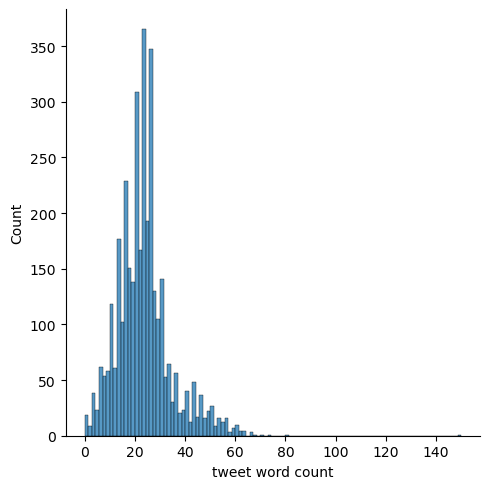

In [16]:
sns.displot(sample_corpus, x='tweet word count')
plt.show()

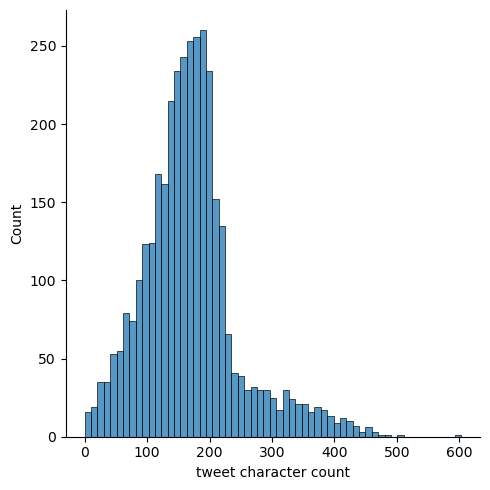

In [17]:
sns.displot(sample_corpus, x='tweet character count')
plt.show()

In [18]:
longest_tweet = sample_corpus[sample_corpus['tweet character count'] == 604]


In [19]:
sample_corpus['tweet character count']

512422    124
836410    305
780930    119
688254    220
107340    120
         ... 
227491     73
260284    203
787179    101
477546    114
327656    178
Name: tweet character count, Length: 3550, dtype: int64

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [20]:
sample_corpus.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,Cleaned Tweets,C Tweets String,tweet word count,tweet character count
512422,1.167490e+18,RepJoshG,2019-08-30T13:24:21-04:00,"(2/2) ...new additions, including a space for ...",Josh Gottheimer,Rep,3-Jan-17,3/8/1975,M,NJ,5,Democrat,"1,601,933","2,148,278","2,125,101","1,477,568","[22, new, additions, including, space, senior,...",22 new additions including space senior progra...,18,124
836410,1.322260e+18,RepLloydDoggett,2020-10-30T15:51:54-04:00,REMINDER: Today is the last day to make histor...,Lloyd Doggett,Rep,3-Jan-95,10/6/1946,M,TX,35,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843","[REMINDER, Today, day, history, vote, early, P...",REMINDER Today day history vote early Polls op...,53,305
780930,1.164660e+18,JohnCornyn,2019-08-22T18:06:54-04:00,RT @JeffBoydTX #tbt to both endorsements from ...,John Cornyn,Sen,2-Dec-02,2/2/1952,M,TX,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[JeffBoydTX, tbt, endorsements, TX, Senators, ...",JeffBoydTX tbt endorsements TX Senators Than...,15,119
688254,1.187430e+18,SenBobCasey,2019-10-24T14:24:21-04:00,Deputy Assistant Secretary of Defense Laura Co...,Bob Casey Jr.,Sen,3-Jan-07,4/13/1960,M,PA,Senate,Democrat,"2,970,733","2,926,441","2,990,274","2,680,434","[Deputy, Assistant, Secretary, Defense, Laura,...",Deputy Assistant Secretary Defense Laura Coope...,25,220
107340,1.223390e+18,SenFeinstein,2020-01-31T18:41:10-05:00,Jurors in a trial should have access to all th...,Dianne Feinstein,Sen,4-Nov-92,6/22/1933,F,CA,Senate,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[Jurors, trial, access, relevant, information,...",Jurors trial access relevant information casti...,17,120


In [21]:
sample_corpus[sample_corpus['tweet character count'] > 600]['C Tweets String'].iloc[0]

'I asked Mark Zuckerberg FSCDems thinks Libra regulated like bank He said   I asked thinks Libra overseen SEC He nt answer clearly    This concerning considering Facebooks advertising monopoly amp corporate power QT TakeOnWallSt FSCDems RepMaxineWaters TaxJusticeAfric latindadd LawyersofAfrica AsianPeoplesMvt facebook civilrightsorg ColorOfChange BradSherman LacyClayMO1 natfairhouse ACREcampaigns RepAlGreen RepAOC AOC RepChuyGarcia Should Libra regulated bank Should Libra regulated SECYou’re unable clear answers laws apply project concerning given advertising monopoly amp corporate power libraindc'

In [22]:
sample_corpus['polarity'] = sample_corpus['C Tweets String'].map(lambda text: TextBlob(text).sentiment.polarity)
sample_corpus['subjectivity'] = sample_corpus['C Tweets String'].map(lambda text: TextBlob(text).sentiment.subjectivity)
sample_corpus.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,Cleaned Tweets,C Tweets String,tweet word count,tweet character count,polarity,subjectivity
512422,1.167490e+18,RepJoshG,2019-08-30T13:24:21-04:00,"(2/2) ...new additions, including a space for ...",Josh Gottheimer,Rep,3-Jan-17,3/8/1975,M,NJ,...,"1,601,933","2,148,278","2,125,101","1,477,568","[22, new, additions, including, space, senior,...",22 new additions including space senior progra...,18,124,0.468182,0.602273
836410,1.322260e+18,RepLloydDoggett,2020-10-30T15:51:54-04:00,REMINDER: Today is the last day to make histor...,Lloyd Doggett,Rep,3-Jan-95,10/6/1946,M,TX,...,"4,685,047","3,877,868","3,308,124","4,569,843","[REMINDER, Today, day, history, vote, early, P...",REMINDER Today day history vote early Polls op...,53,305,0.057143,0.400000
780930,1.164660e+18,JohnCornyn,2019-08-22T18:06:54-04:00,RT @JeffBoydTX #tbt to both endorsements from ...,John Cornyn,Sen,2-Dec-02,2/2/1952,M,TX,...,"4,685,047","3,877,868","3,308,124","4,569,843","[JeffBoydTX, tbt, endorsements, TX, Senators, ...",JeffBoydTX tbt endorsements TX Senators Than...,15,119,0.500000,1.000000
688254,1.187430e+18,SenBobCasey,2019-10-24T14:24:21-04:00,Deputy Assistant Secretary of Defense Laura Co...,Bob Casey Jr.,Sen,3-Jan-07,4/13/1960,M,PA,...,"2,970,733","2,926,441","2,990,274","2,680,434","[Deputy, Assistant, Secretary, Defense, Laura,...",Deputy Assistant Secretary Defense Laura Coope...,25,220,0.600000,0.900000
107340,1.223390e+18,SenFeinstein,2020-01-31T18:41:10-05:00,Jurors in a trial should have access to all th...,Dianne Feinstein,Sen,4-Nov-92,6/22/1933,F,CA,...,"4,483,814","8,753,792","7,854,285","4,839,958","[Jurors, trial, access, relevant, information,...",Jurors trial access relevant information casti...,17,120,0.550000,0.900000


#### Lib Rep (Omar) vs Conservative Sen (Cruz)

In [23]:
cruz_omar_corpus = sample_corpus[sample_corpus['name_wikipedia'].isin(['Ted Cruz', 'Ilhan Omar'])]

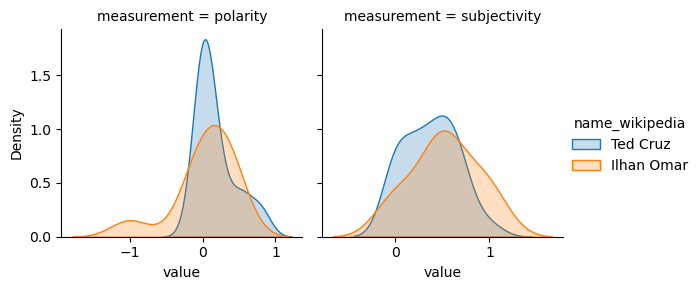

In [24]:
# KDE of polarity and sentiment  by legislator
long_df = cruz_omar_corpus.melt(id_vars=['name_wikipedia'], value_vars=['polarity', 'subjectivity'], var_name='measurement', value_name='value')

# Use FacetGrid to create a grid of plots based on the 'measurement' column
g = sns.FacetGrid(long_df, col='measurement', hue='name_wikipedia', sharex=False, sharey=True)

# Map kdeplot onto each subset of the data
g = g.map(sns.kdeplot, 'value', fill=True).add_legend()

plt.show()

#### Dems vs Republicans 

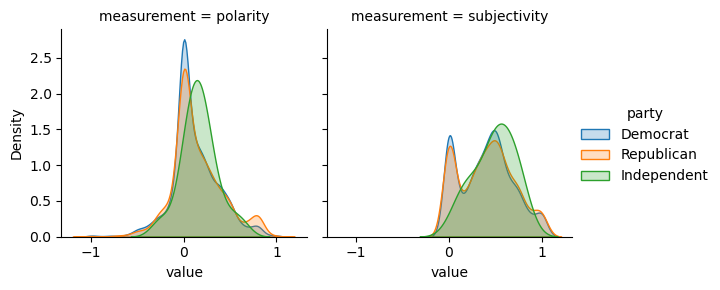

In [26]:
# KDE of polarity and sentiment by legislator
# sns.displot(sample_corpus,            # specify data
#             x="polarity",    # specify x-axix feature 
#             hue = "party", # color by loan product
#             kind='kde',
#             fill='true') # color by loan product
# plt.show()

party_long_df = sample_corpus.melt(id_vars=['party'], value_vars=['polarity', 'subjectivity'], var_name='measurement', value_name='value')

g = sns.FacetGrid(party_long_df, col='measurement', hue='party')

g = g.map(sns.kdeplot, 'value', fill=True).add_legend()


#### Senators vs Representatives 

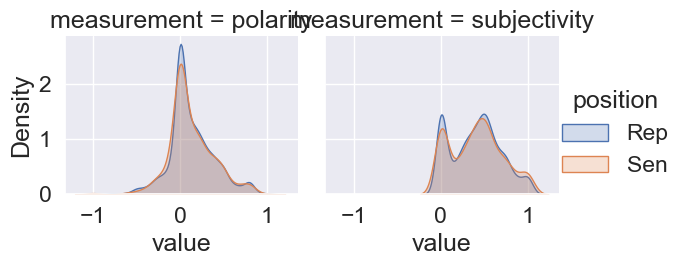

In [181]:
chamber_long_df = sample_corpus.melt(id_vars=['position'], value_vars=['polarity', 'subjectivity'], var_name='measurement', value_name='value')

g = sns.FacetGrid(chamber_long_df, col='measurement', hue='position')

g = g.map(sns.kdeplot, 'value', fill=True).add_legend()

##### Interesting how similar the distributions are across the spectrum. The positive leaning might be due to any particular person or party wanting to stress good things they (or their party) have done for the country/their consititutents 

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

In [28]:
sample_corpus.columns

Index(['tweet_id', 'screen_name', 'datetime', 'text', 'name_wikipedia',
       'position', 'joined_congress_date', 'birthday', 'gender', 'state',
       'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'Cleaned Tweets', 'C Tweets String',
       'tweet word count', 'tweet character count', 'polarity',
       'subjectivity'],
      dtype='object')

### Engineered Text Features

In [29]:
# Engineered Features
engineered_features = sample_corpus[['polarity', 'subjectivity','tweet word count', 'tweet character count']]

engineered_features.head()

,polarity,subjectivity,tweet word count,tweet character count
512422,0.468182,0.602273,18,124
836410,0.057143,0.400000,53,305
780930,0.500000,1.000000,15,119
688254,0.600000,0.900000,25,220
107340,0.550000,0.900000,17,120


### Bag-of-words or Tf-idf

In [30]:
sample_corpus['C Tweets String']

512422    22 new additions including space senior progra...
836410    REMINDER Today day history vote early Polls op...
780930    JeffBoydTX tbt endorsements TX Senators   Than...
688254    Deputy Assistant Secretary Defense Laura Coope...
107340    Jurors trial access relevant information casti...
                                ...                        
227491    So far president defense unfair present facts ...
260284    During today Rules debate I pointed HR 1815 HR...
787179    University Texas Rio Grande Valley provide fre...
477546    Montana health care workers lines combating CO...
327656    According DNIRatcliffe American families spend...
Name: C Tweets String, Length: 3550, dtype: object

In [31]:
# Frequency Based featurization

# First create the Tf-idf feature 
X = sample_corpus['C Tweets String']
tf = TfidfVectorizer(tokenizer=rem_punc_stop)
tfidf_matrix = tf.fit_transform(X)
dense_tfidf = tfidf_matrix.todense()

In [32]:
tfidf_df = pd.DataFrame(dense_tfidf, columns=tf.get_feature_names_out())

tfidf_df.head()

,,,,,,,,0,057,1,...,🥳,🥴,🥽,🦃,🧑,🧒,🧪,🧱,🧵,🧼
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.089226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.082445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Word Embedding

In [37]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

gn_model = gensim.models.KeyedVectors.load_word2vec_format('/Users/quinn/Documents/GradSchool/Spring2024/CSS/Computational-Social-Science-Training-Program/data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [38]:
sample_corpus.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,Cleaned Tweets,C Tweets String,tweet word count,tweet character count,polarity,subjectivity
512422,1.167490e+18,RepJoshG,2019-08-30T13:24:21-04:00,"(2/2) ...new additions, including a space for ...",Josh Gottheimer,Rep,3-Jan-17,3/8/1975,M,NJ,...,"1,601,933","2,148,278","2,125,101","1,477,568","[22, new, additions, including, space, senior,...",22 new additions including space senior progra...,18,124,0.468182,0.602273
836410,1.322260e+18,RepLloydDoggett,2020-10-30T15:51:54-04:00,REMINDER: Today is the last day to make histor...,Lloyd Doggett,Rep,3-Jan-95,10/6/1946,M,TX,...,"4,685,047","3,877,868","3,308,124","4,569,843","[REMINDER, Today, day, history, vote, early, P...",REMINDER Today day history vote early Polls op...,53,305,0.057143,0.400000
780930,1.164660e+18,JohnCornyn,2019-08-22T18:06:54-04:00,RT @JeffBoydTX #tbt to both endorsements from ...,John Cornyn,Sen,2-Dec-02,2/2/1952,M,TX,...,"4,685,047","3,877,868","3,308,124","4,569,843","[JeffBoydTX, tbt, endorsements, TX, Senators, ...",JeffBoydTX tbt endorsements TX Senators Than...,15,119,0.500000,1.000000
688254,1.187430e+18,SenBobCasey,2019-10-24T14:24:21-04:00,Deputy Assistant Secretary of Defense Laura Co...,Bob Casey Jr.,Sen,3-Jan-07,4/13/1960,M,PA,...,"2,970,733","2,926,441","2,990,274","2,680,434","[Deputy, Assistant, Secretary, Defense, Laura,...",Deputy Assistant Secretary Defense Laura Coope...,25,220,0.600000,0.900000
107340,1.223390e+18,SenFeinstein,2020-01-31T18:41:10-05:00,Jurors in a trial should have access to all th...,Dianne Feinstein,Sen,4-Nov-92,6/22/1933,F,CA,...,"4,483,814","8,753,792","7,854,285","4,839,958","[Jurors, trial, access, relevant, information,...",Jurors trial access relevant information casti...,17,120,0.550000,0.900000


In [39]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in word2vec_model.key_to_index]

    # Ensure doc is not empty to avoid ValueError in np.mean()
    if len(doc) == 0:
        return numpy.zeros(word2vec_model.vector_size)
    return numpy.mean(word2vec_model[doc], axis=0)


# create empty list
empty_list_embeddings_means = []

# loop over each each token
# feel like this can be redone with apply 
for doc in sample_corpus['Cleaned Tweets']: # append the vector for each document
    empty_list_embeddings_means.append(document_vector(gn_model, doc))

# convert the list to array
doc_average_embeddings = numpy.array(empty_list_embeddings_means) 

# print averages
doc_average_embeddings

array([[-0.03841782,  0.06248093,  0.05246735, ..., -0.06111145,
         0.05634689, -0.03465271],
       [ 0.00983412, -0.00911187,  0.03154568, ..., -0.06121962,
         0.00279677, -0.00801866],
       [ 0.04244559, -0.04419599, -0.03229632, ...,  0.02584839,
        -0.17302595,  0.0181754 ],
       ...,
       [ 0.04434482, -0.04063277, -0.04615922, ..., -0.03873513,
         0.06526253, -0.05970903],
       [ 0.06016922,  0.08461761,  0.04866982, ..., -0.02181244,
         0.08396912,  0.02991867],
       [ 0.06552124,  0.03700087,  0.03592936, ...,  0.05431112,
         0.10396746, -0.07621256]])

In [40]:
# embedding based featurization
word2vec_gn_features_df = pd.DataFrame(doc_average_embeddings)

word2vec_gn_features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.038418,0.062481,0.052467,-0.029095,-0.021294,-0.148244,0.093233,-0.058420,-0.041405,0.022385,...,-0.084661,-0.013880,-0.015656,0.001251,-0.000031,-0.012856,0.026054,-0.061111,0.056347,-0.034653
1,0.009834,-0.009112,0.031546,0.024441,-0.045244,-0.021091,-0.037925,-0.015371,0.099037,0.071972,...,0.006118,-0.005946,-0.089345,-0.028629,0.004591,-0.140627,-0.082745,-0.061220,0.002797,-0.008019
2,0.042446,-0.044196,-0.032296,0.088937,-0.191650,-0.029157,-0.095773,0.006888,-0.008859,0.050773,...,0.012800,-0.049648,0.068638,-0.060547,0.016619,-0.160039,0.057966,0.025848,-0.173026,0.018175
3,0.066534,0.051730,-0.009318,-0.033860,-0.069072,-0.049692,0.015010,-0.089258,0.068152,-0.033833,...,-0.095728,-0.106619,-0.060093,0.019764,-0.045026,-0.076973,-0.040029,-0.041150,0.053315,0.061805
4,-0.042156,-0.014002,0.007935,0.047051,-0.031674,0.021021,0.091000,0.014878,0.083898,0.027732,...,-0.084229,0.027889,0.029552,-0.051505,-0.020270,-0.009055,0.007202,-0.122429,0.025912,0.010950


## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [41]:
!pip install xgboost

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier



### Engineered Features

In [92]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])

# set up the labels for each model. One for Dem vs Rep and one for sen vs rep 
y_party = sample_corpus['party']
y_position = sample_corpus['position']

# split data into train, test 

X_train, X_test, y_train_party, y_test_party = train_test_split(engineered_features, 
                                                                y_party, 
                                                                test_size=0.3,
                                                                random_state=123)

# load classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# encode the data to numerical features 
# initialize encoder
le = LabelEncoder()

# Fit and transform the target variable to encode labels into integers
y_train_party_encoded = le.fit_transform(y_train_party)
y_test_party_encoded = le.transform(y_test_party)


# Fit to data
xgb_model = xgb.fit(X_train, y_train_party_encoded.ravel())

# predict 
y_party_predict = xgb_model.predict(X_test)

# retransform
y_party_predict_ef = le.inverse_transform(y_party_predict)
party_confusion_matrix = confusion_matrix(y_test_party, y_party_predict_ef, normalize='true')

In [93]:
party_confusion_matrix

array([[0.76979472, 0.        , 0.23020528],
       [1.        , 0.        , 0.        ],
       [0.76127321, 0.00265252, 0.23607427]])

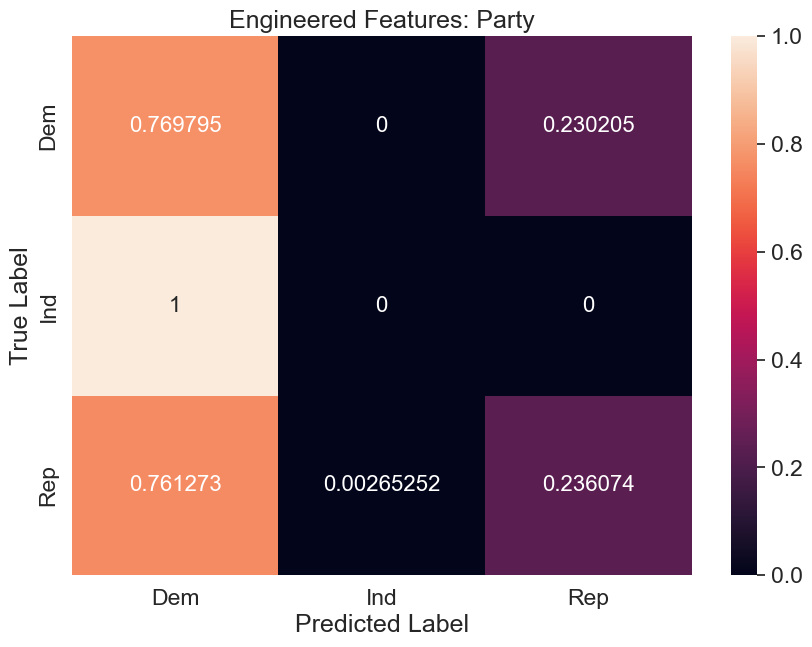

In [94]:
# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.set(font_scale=1.5)
sns.heatmap(party_confusion_matrix,
            annot=True, 
            annot_kws={"size": 16},
            fmt='g',
            xticklabels=['Dem', 'Ind', 'Rep'],
            yticklabels=['Dem', 'Ind', 'Rep'])

plt.title('Engineered Features: Party')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [95]:
accuracy_score(y_test_party, y_party_predict_ef)

0.5765258215962441

In [96]:
## Position prediction 
X_train, X_test, y_train_position, y_test_position = train_test_split(engineered_features, 
                                                                y_position, 
                                                                test_size=0.3,
                                                                random_state=123)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# encode
y_train_position_enc = le.fit_transform(y_train_position)
y_test_position_enc = le.fit_transform(y_test_position)

# Fit to data
xgb_position_model = xgb.fit(X_train, y_train_position_enc.ravel())

# predict 
y_position_predict = xgb_position_model.predict(X_test)

# retransform
y_position_predict = le.inverse_transform(y_position_predict)

# confusion matrix
position_confusion_matrix = confusion_matrix(y_test_position, y_position_predict, normalize='true')


In [97]:
position_confusion_matrix

array([[0.90346535, 0.09653465],
       [0.92217899, 0.07782101]])

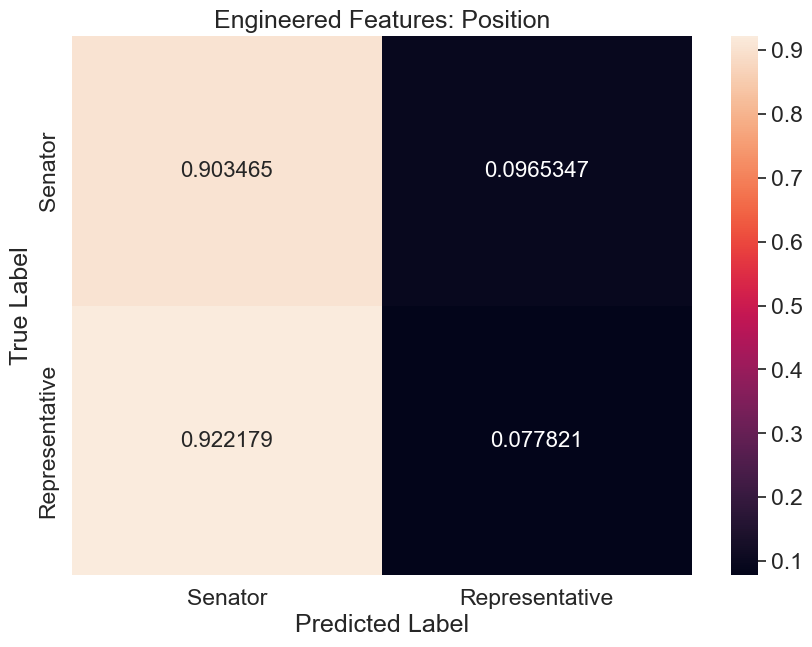

In [98]:
# Plot matrix 

plt.figure(figsize=(10,7))
sns.set(font_scale=1.5)
sns.heatmap(position_confusion_matrix,
            annot=True, 
            annot_kws={"size": 16},
            fmt='g',
            xticklabels=['Senator', 'Representative'],
            yticklabels=['Senator', 'Representative'])

plt.title('Engineered Features: Position')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [99]:
accuracy_score(y_test_position, y_position_predict)

0.704225352112676

### TFIDF

In [100]:

X_train, X_test, y_train_party, y_test_party = train_test_split(tfidf_df, 
                                                    y_party, 
                                                    test_size=0.20, 
                                                    random_state = 123)
# load classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# encode the data to numerical features 
# initialize encoder
le = LabelEncoder()

# Fit and transform the target variable to encode labels into integers
y_train_party_encoded = le.fit_transform(y_train_party)
y_test_party_encoded = le.transform(y_test_party)


# Fit to data
xgb_model = xgb.fit(X_train, y_train_party_encoded.ravel())

# predict 
y_party_predict = xgb_model.predict(X_test)

# retransform
y_party_predict_ef = le.inverse_transform(y_party_predict)
party_confusion_matrix_tfidf = confusion_matrix(y_test_party, y_party_predict_ef, normalize='true')


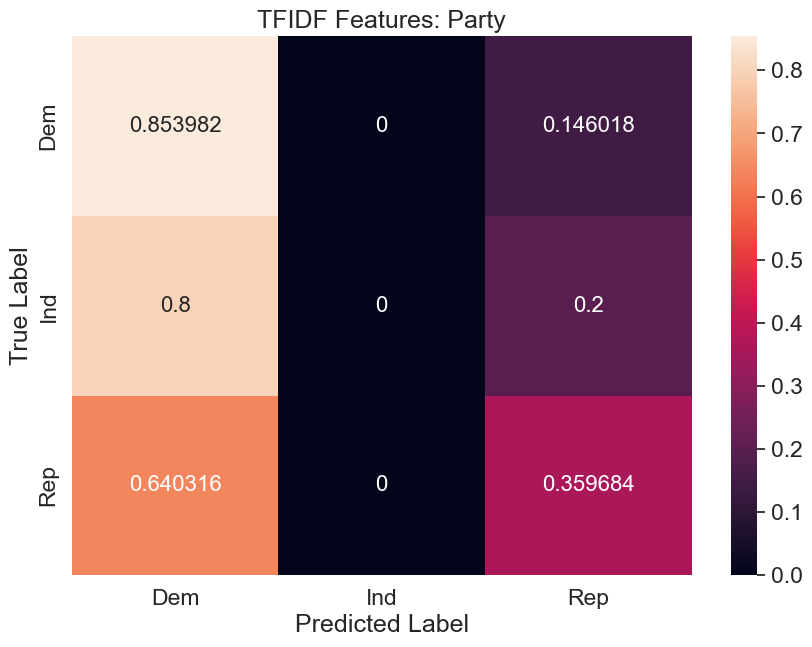

In [103]:
# Plot cf matrix 

plt.figure(figsize=(10,7))
sns.set(font_scale=1.5)
sns.heatmap(party_confusion_matrix_tfidf,
            annot=True, 
            annot_kws={"size": 16},
            fmt='g',
            xticklabels=['Dem', 'Ind', 'Rep'],
            yticklabels=['Dem', 'Ind', 'Rep'])

plt.title('TFIDF Features: Party')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [104]:
accuracy_score(y_test_party, y_party_predict_ef)

0.671830985915493

In [105]:
# XGB
X_train, X_test, y_train_position, y_test_position = train_test_split(tfidf_df, 
                                                    y_position, 
                                                    test_size=0.20, 
                                                    random_state = 123)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# encode
y_train_position_enc = le.fit_transform(y_train_position)
y_test_position_enc = le.fit_transform(y_test_position)

# Fit to data
xgb_position_model = xgb.fit(X_train, y_train_position_enc.ravel())

# predict 
y_position_predict = xgb_position_model.predict(X_test)

# retransform
y_position_predict = le.inverse_transform(y_position_predict)

# confusion matrix
position_confusion_matrix_tfidf = confusion_matrix(y_test_position, y_position_predict, normalize='true')

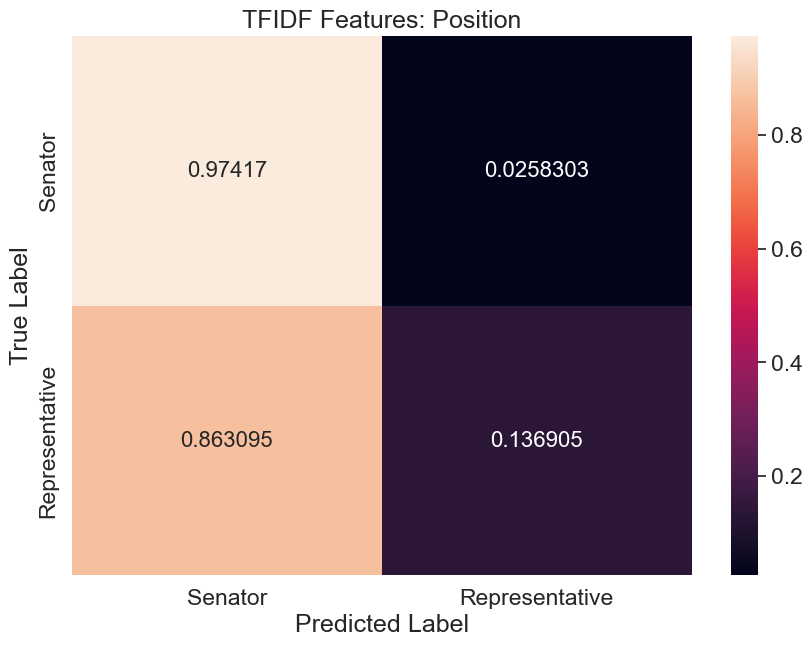

In [113]:
# Plot matrix 

plt.figure(figsize=(10,7))
sns.set(font_scale=1.5)
sns.heatmap(position_confusion_matrix_tfidf,
            annot=True, 
            annot_kws={"size": 16},
            fmt='g',
            xticklabels=['Senator', 'Representative'],
            yticklabels=['Senator', 'Representative'])

plt.title('TFIDF Features: Position')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [108]:
accuracy_score(y_test_position, y_position_predict)

0.776056338028169

### Word Embeddings 


In [114]:
# XGBoost Again 
X_train, X_test, y_train_party, y_test_party = train_test_split(word2vec_gn_features_df, 
                                                    y_party, 
                                                    test_size=0.20, 
                                                    random_state = 123)
# initialize the model
xgboost_w2v = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# encode
y_train_party_enc = le.fit_transform(y_train_party)
y_test_party_enc = le.fit_transform(y_test_party)

# fit model
xgb_w2v_model_party = xgboost_w2v.fit(X_train, y_train_party_enc.ravel())

# Predict
y_pred_party = xgb_w2v_model_party.predict(X_test)

# confusion matrix
party_confusion_matrix_w2v = confusion_matrix(y_test_party_enc, y_pred_party, normalize='true')

# accuracy 
party_accuracy = accuracy_score(y_test_party_enc, y_pred_party)

In [115]:
party_confusion_matrix_w2v

array([[0.86725664, 0.        , 0.13274336],
       [0.8       , 0.        , 0.2       ],
       [0.67193676, 0.        , 0.32806324]])

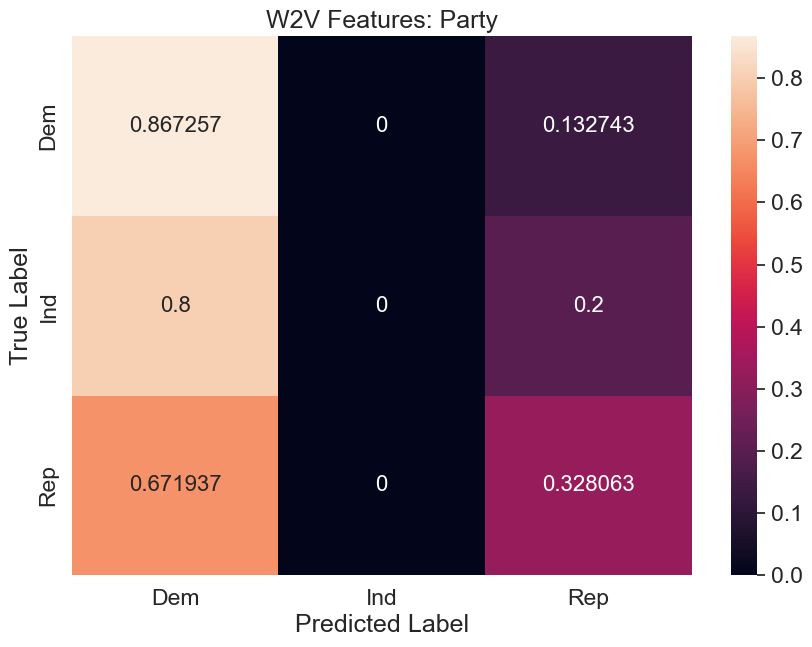

In [116]:
# Plot cf matrix 

plt.figure(figsize=(10,7))
sns.set(font_scale=1.5)
sns.heatmap(party_confusion_matrix_w2v,
            annot=True, 
            annot_kws={"size": 16},
            fmt='g',
            xticklabels=['Dem', 'Ind', 'Rep'],
            yticklabels=['Dem', 'Ind', 'Rep'])

plt.title('W2V Features: Party')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [117]:
party_accuracy

0.6690140845070423

In [118]:
# Try XGBoost Again 
X_train, X_test, y_train_position, y_test_position = train_test_split(word2vec_gn_features_df, 
                                                    y_position, 
                                                    test_size=0.20, 
                                                    random_state = 123)
# initialize the model
xgboost_w2v = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# encode
y_train_position_enc = le.fit_transform(y_train_position)
y_test_position_enc = le.fit_transform(y_test_position)

# fit model
xgb_w2v_model_position = xgboost_w2v.fit(X_train, y_train_position_enc.ravel())

# Predict
y_pred_position = xgb_w2v_model_position.predict(X_test)

# confusion matrix
position_confusion_matrix_w2v = confusion_matrix(y_test_position_enc, y_pred_position, normalize='true')

# accuracy 
position_accuracy = accuracy_score(y_test_position_enc, y_pred_position)

In [119]:
position_accuracy

0.7535211267605634

In [120]:
position_confusion_matrix_w2v

array([[0.96494465, 0.03505535],
       [0.92857143, 0.07142857]])

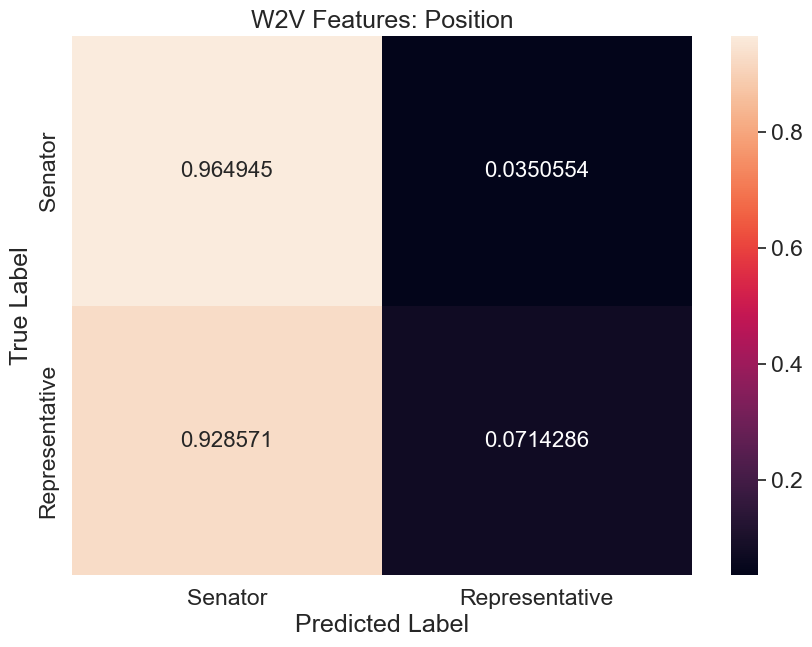

In [121]:
# Plot matrix 

plt.figure(figsize=(10,7))
sns.set(font_scale=1.5)
sns.heatmap(position_confusion_matrix_w2v,
            annot=True, 
            annot_kws={"size": 16},
            fmt='g',
            xticklabels=['Senator', 'Representative'],
            yticklabels=['Senator', 'Representative'])

plt.title('W2V Features: Position')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Two Combined Models

* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

In [182]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
sample_corpus.columns

Index(['tweet_id', 'screen_name', 'datetime', 'text', 'name_wikipedia',
       'position', 'joined_congress_date', 'birthday', 'gender', 'state',
       'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'Cleaned Tweets', 'C Tweets String',
       'tweet word count', 'tweet character count', 'polarity',
       'subjectivity'],
      dtype='object')

In [183]:
non_text_features = sample_corpus[['gender', 'state', 'trump_2016_state_share', 'clinton_2016_state_share',
                                   'obama_2012_state_share', 'romney_2012_state_share']] # others such as district number, name, date, etc are assumed irrelevant

non_text_features.head()

,gender,state,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
512422,M,NJ,"1,601,933","2,148,278","2,125,101","1,477,568"
836410,M,TX,"4,685,047","3,877,868","3,308,124","4,569,843"
780930,M,TX,"4,685,047","3,877,868","3,308,124","4,569,843"
688254,M,PA,"2,970,733","2,926,441","2,990,274","2,680,434"
107340,F,CA,"4,483,814","8,753,792","7,854,285","4,839,958"


In [184]:
# Convert object columns to category if applicable
for col in ['gender', 'state']:  # Add other categorical columns as needed
    non_text_features.loc[:,col] = pd.get_dummies(non_text_features).reset_index(drop=True)

# Convert share columns to numeric, removing commas
for col in ['trump_2016_state_share', 'clinton_2016_state_share', 
            'obama_2012_state_share', 'romney_2012_state_share']:
    non_text_features.loc[:,col] = pd.to_numeric(non_text_features[col].str.replace(',', ''), errors='coerce')


# One-hot encode categorical variables
non_text_features = pd.get_dummies(non_text_features, columns=['gender', 'state'])

# non-text features with XGBoost, position
X_train, X_test, y_train_position, y_test_position = train_test_split(non_text_features, 
                                                    y_position, 
                                                    test_size=0.20, 
                                                    random_state = 123)
# initialize the model
xgboost_ntf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# encode
le.fit(y_train_position)
y_train_position_enc = le.transform(y_train_position)
y_test_position_enc = le.transform(y_test_position)

# fit model
xgb_ntf_model_position = xgboost_ntf.fit(X_train, y_train_position_enc.ravel())

# Predict
y_pred_position = xgb_ntf_model_position.predict(X_test)

# confusion matrix
position_confusion_matrix_ntf = confusion_matrix(y_test_position_enc, y_pred_position, normalize='true')

# accuracy 
position_accuracy = accuracy_score(y_test_position_enc, y_pred_position)

/var/folders/m4/jl2xh8413dvg0wnf31767gsh0000gn/T/ipykernel_79557/1264894843.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_text_features.loc[:,col] = pd.get_dummies(non_text_features).reset_index(drop=True)
/var/folders/m4/jl2xh8413dvg0wnf31767gsh0000gn/T/ipykernel_79557/1264894843.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_text_features.loc[:,col] = pd.get_dummies(non_text_features).reset_index(drop=True)
/var/folders/m4/jl2xh8413dvg0wnf31767gsh0000gn/T/ipykernel_79557/1264894843.py:8

In [186]:
position_accuracy

0.8211267605633803

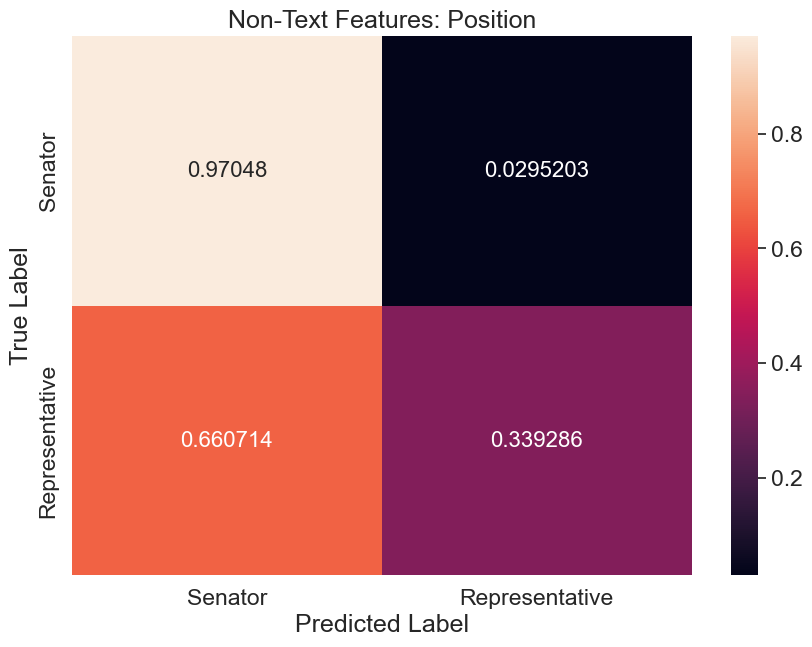

In [185]:
# Plot matrix 

plt.figure(figsize=(10,7))
sns.set(font_scale=1.5)
sns.heatmap(position_confusion_matrix_ntf,
            annot=True, 
            annot_kws={"size": 16},
            fmt='g',
            xticklabels=['Senator', 'Representative'],
            yticklabels=['Senator', 'Representative'])

plt.title('Non-Text Features: Position')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [163]:
# XGBoost Again 
X_train, X_test, y_train_party, y_test_party = train_test_split(non_text_features, 
                                                    y_party, 
                                                    test_size=0.20, 
                                                    random_state = 123)
# initialize the model
xgboost_ntf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# encode
le.fit(y_train_party)
y_train_party_enc = le.transform(y_train_party)
y_test_party_enc = le.transform(y_test_party)

# fit model
xgb_ntf_model_party = xgboost_ntf.fit(X_train, y_train_party_enc.ravel())

# Predict
y_pred_party = xgb_ntf_model_party.predict(X_test)

# confusion matrix
party_confusion_matrix_ntf = confusion_matrix(y_test_party_enc, y_pred_party, normalize='true')

# accuracy 
party_accuracy = accuracy_score(y_test_party_enc, y_pred_party)

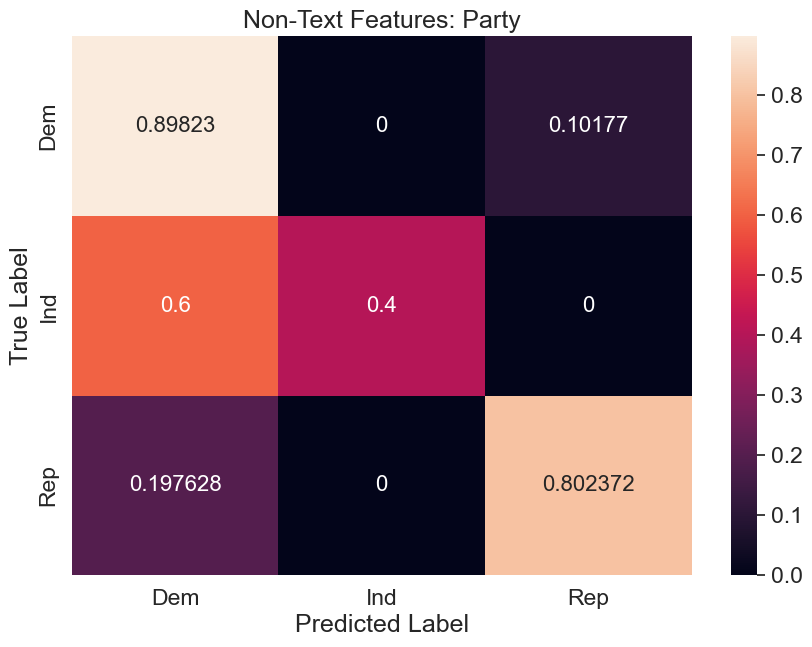

In [164]:
# Plot cf matrix 

plt.figure(figsize=(10,7))
sns.set(font_scale=1.5)
sns.heatmap(party_confusion_matrix_ntf,
            annot=True, 
            annot_kws={"size": 16},
            fmt='g',
            xticklabels=['Dem', 'Ind', 'Rep'],
            yticklabels=['Dem', 'Ind', 'Rep'])

plt.title('Non-Text Features: Party')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [165]:
party_accuracy

0.8605633802816901

#### Combined Text and Non-Text

In [166]:
combined_features = non_text_features.reset_index(drop=True).join(word2vec_gn_features_df)

In [167]:
combined_features

,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,gender_0,gender_1,0,1,2,3,...,290,291,292,293,294,295,296,297,298,299
0,1601933,2148278,2125101,1477568,1,0,-0.038418,0.062481,0.052467,-0.029095,...,-0.084661,-0.013880,-0.015656,0.001251,-0.000031,-0.012856,0.026054,-0.061111,0.056347,-0.034653
1,4685047,3877868,3308124,4569843,1,0,0.009834,-0.009112,0.031546,0.024441,...,0.006118,-0.005946,-0.089345,-0.028629,0.004591,-0.140627,-0.082745,-0.061220,0.002797,-0.008019
2,4685047,3877868,3308124,4569843,1,0,0.042446,-0.044196,-0.032296,0.088937,...,0.012800,-0.049648,0.068638,-0.060547,0.016619,-0.160039,0.057966,0.025848,-0.173026,0.018175
3,2970733,2926441,2990274,2680434,1,0,0.066534,0.051730,-0.009318,-0.033860,...,-0.095728,-0.106619,-0.060093,0.019764,-0.045026,-0.076973,-0.040029,-0.041150,0.053315,0.061805
4,4483814,8753792,7854285,4839958,0,1,-0.042156,-0.014002,0.007935,0.047051,...,-0.084229,0.027889,0.029552,-0.051505,-0.020270,-0.009055,0.007202,-0.122429,0.025912,0.010950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3545,4617886,4504975,4237756,4163447,0,1,-0.016650,0.018234,0.071155,0.017468,...,-0.063260,0.013860,-0.145358,0.027664,-0.072949,-0.034137,0.105786,-0.018114,0.075024,0.014508
3546,2089104,1877963,1773827,2078688,1,0,-0.051743,0.065034,0.029184,0.067322,...,-0.069901,-0.063028,-0.070923,0.028469,-0.039975,-0.036555,0.009244,-0.018335,0.072239,0.028762
3547,4685047,3877868,3308124,4569843,1,0,0.044345,-0.040633,-0.046159,0.198783,...,-0.116649,-0.061579,-0.144731,0.031605,0.146795,-0.005094,0.022963,-0.038735,0.065263,-0.059709
3548,279240,177709,201839,267928,1,0,0.060169,0.084618,0.048670,0.115402,...,-0.095436,-0.007019,-0.058449,0.030157,0.031451,0.054169,-0.064620,-0.021812,0.083969,0.029919


In [168]:
# combined features with XGBoost, position
X_train, X_test, y_train_position, y_test_position = train_test_split(combined_features, 
                                                    y_position, 
                                                    test_size=0.20, 
                                                    random_state = 123)
# initialize the model
xgboost_comb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# encode
le.fit(y_train_position)
y_train_position_enc = le.transform(y_train_position)
y_test_position_enc = le.transform(y_test_position)

# fit model
xgb_comb_model_position = xgboost_comb.fit(X_train, y_train_position_enc.ravel())

# Predict
y_pred_position = xgb_comb_model_position.predict(X_test)

# confusion matrix
position_confusion_matrix_comb = confusion_matrix(y_test_position_enc, y_pred_position, normalize='true')

# accuracy 
position_accuracy = accuracy_score(y_test_position_enc, y_pred_position)

In [169]:
position_accuracy

0.8028169014084507

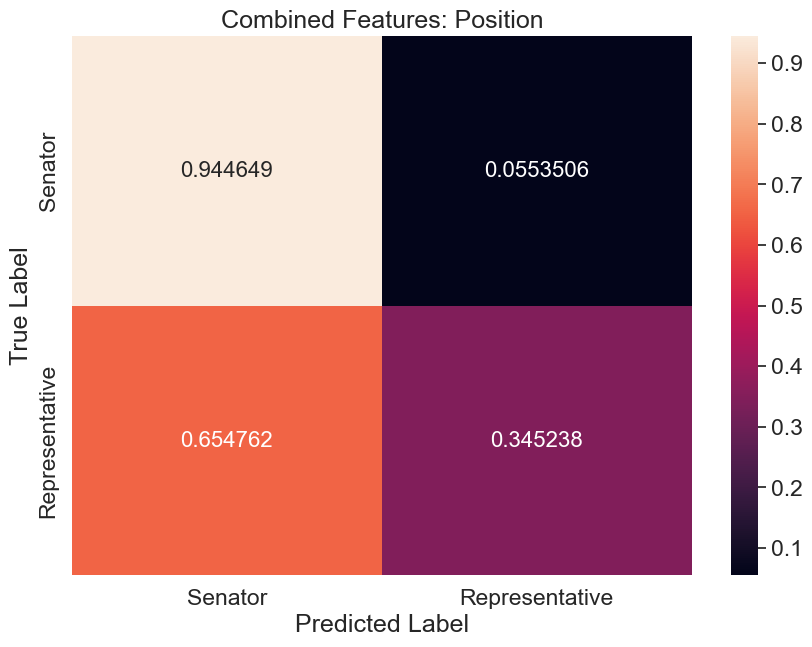

In [173]:
# Plot matrix 

plt.figure(figsize=(10,7))
sns.set(font_scale=1.5)
sns.heatmap(position_confusion_matrix_comb,
            annot=True, 
            annot_kws={"size": 16},
            fmt='g',
            xticklabels=['Senator', 'Representative'],
            yticklabels=['Senator', 'Representative'])

plt.title('Combined Features: Position')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [174]:
X_train, X_test, y_train_party, y_test_party = train_test_split(combined_features, 
                                                    y_party, 
                                                    test_size=0.20, 
                                                    random_state = 123)
# initialize the model
xgboost_comb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# encode
le.fit(y_train_party)
y_train_party_enc = le.transform(y_train_party)
y_test_party_enc = le.transform(y_test_party)

# fit model
xgb_comb_model_party = xgboost_ntf.fit(X_train, y_train_party_enc.ravel())

# Predict
y_pred_party = xgb_comb_model_party.predict(X_test)

# confusion matrix
party_confusion_matrix_comb = confusion_matrix(y_test_party_enc, y_pred_party, normalize='true')

# accuracy 
party_accuracy = accuracy_score(y_test_party_enc, y_pred_party)

In [175]:
party_accuracy

0.8394366197183099

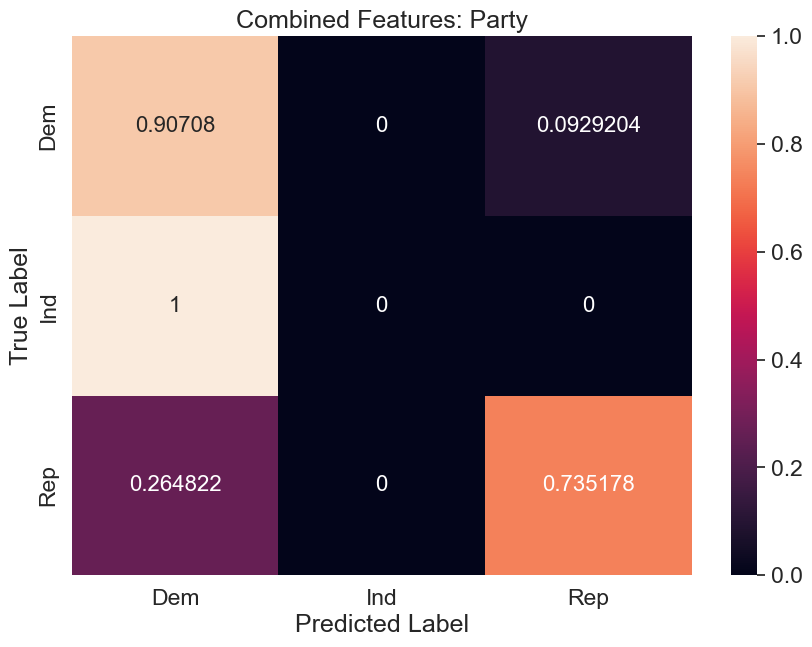

In [176]:
# Plot cf matrix 

plt.figure(figsize=(10,7))
sns.set(font_scale=1.5)
sns.heatmap(party_confusion_matrix_comb,
            annot=True, 
            annot_kws={"size": 16},
            fmt='g',
            xticklabels=['Dem', 'Ind', 'Rep'],
            yticklabels=['Dem', 'Ind', 'Rep'])

plt.title('Combined Features: Party')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Your Answer Here**

Particular words, aspects, symbols etc may be specific to a corpus. Redacted texts may be displayed as a string of "X's", URLs may be present and unwanted in tweets, return characters may or may not be desired, date formats might need to be changed, etc. Ultimately, the documents' text ought to be representative of information we are interested in, and that can change from corpus to corpus. 

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Your Answer Here**
Both sentitment and polarity scores were quite aligned between Democrats and Republicans as well as Senators and Representatives. The most obvious difference was the frequency, which was expected for Senators vs Representatives given their different populations. If we were to run a t-test to compare the distributions I doubt we would find much of a significant difference if any. However, other measures of subjectivity might have given different results. 

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?


**Your Answer Here**
Validation through supervised models allows for the assessment of whether engineered and discovered features possess true predictive capability, and can help us understand the integrity uncovered during unsupervised phases by testing how well these align with known outcomes. It allows us to combine the broad insights from unsupervised learning with the precise validation capabilities of supervised models, enhancing decision-making and model development through a comprehensive understanding of both data patterns and their predictive relevance.

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Your Answer Here**
The non-text features alone performed the best with the model I chose, XGBoost. I suspect that the text features were in fact fairly similar and very non-linear when embedded. With the small amount of data this was run on, it may not have been enough to distinguish characteristics well enough, whereas non-text features such as Trump Share, State, etc can be very direct and influential features with clearly defined bounds. 

Combining features helps relate information captured from text features to non-text features, and can help contextualize further text features thanks to the information provided by the non-text features. I suspect that with a larger dataset or perhaps a simpler model, such as a logistic regression, this would have been the best-performing dataset. 